<a href="https://colab.research.google.com/github/aruanalucena/br-data-science/blob/master/PROJETO_AWARI_DOEN%C3%87AS_CARDIACAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



É um conjunto de dados limpo e fácil de compreender. No entanto, o significado de alguns dos cabeçalhos das colunas não é óbvio. Eis o que eles significam,

* idade: A idade da pessoa em anos
* sexo: O sexo da pessoa (1 = masculino, 0 = feminino)
* cp: A dor no peito sentida (Valor 1: angina típica, Valor 2: angina atípica, Valor 3: dor nãoanginal, Valor 4: assintomática)
* trestbps: Pressão arterial em repouso da pessoa (mm Hg na admissão ao hospital)
* chol: A medição do colesterol da pessoa em mg/dl
* fbs: O açúcar no sangue em jejum (> 120 mg/dl, 1 = verdadeiro; 0 = falso)
* restecg: Medição electrocardiográfica em repouso (0 = normal, 1 = com anormalidade de onda ST-T, 2 = mostrando provável ou definitiva hipertrofia ventricular esquerda pelo critério destes)
* talachas: O ritmo cardíaco máximo alcançado pela pessoa
* exang: Angina induzida pelo exercício (1 = sim; 0 = não)
* oldpeak: Depressão ST induzida pelo exercício relativo ao repouso ('ST' refere-se a posições na trama do ECG. Ver mais aqui)
* slope: o declive do segmento ST do exercício de pico (Valor 1: subida, Valor 2: plano, Valor 3: descida)
* ca: O número de embarcações principais (0-3)
* thal: Uma doença do sangue chamada talassemia (3 = normal; 6 = defeito fixo; 7 = defeito reversível)
* target: Doença cardíaca (0 = não, 1 = sim)


Para evitar o HARKing ( Hipótes após  resultados conhecidos) vamos dar uma olhada  sobre como a doença cardíaca é diagnosticada, e procurar alguns dos termos acima.

Diagnóstico: O diagnóstico de doença cardíaca é feito com base numa combinação de sinais clínicos e resultados de testes. Os tipos de testes realizados serão escolhidos com base no que o médico pensa que está a fazer 1, desde electrocardiogramas e tomografias computorizadas cardíacas (TAC), a testes de sangue e testes de esforço de exercício 2.

Olhando para a informação dos factores de risco de doenças cardíacas levou-me ao seguinte: colesterol elevado, tensão arterial elevada, diabetes, peso, história familiar e tabagismo 3. De acordo com outra fonte 4, os principais factores que não podem ser alterados são: aumento da idade, sexo masculino e hereditariedade. Note-se que a talassemia, uma das variáveis deste conjunto de dados, é a hereditariedade. Os principais factores que podem ser modificados são: idade crescente, sexo masculino e hereditariedade: Fumar, colesterol elevado, tensão arterial elevada, inactividade física, excesso de peso e ter diabetes. Outros factores incluem o stress, o álcool e a má alimentação/nutrição.

Não vejo qualquer referência ao "número de vasos principais", mas dado que a definição de doença cardíaca é "...o que acontece quando o fornecimento de sangue do coração é bloqueado ou interrompido por uma acumulação de substâncias gordurosas nas artérias coronárias", parece lógico que quanto mais os vasos principais forem bons, e portanto reduzirá a probabilidade de doença cardíaca.
Com as informações acima, a hipotese do modelo tiver alguma capacidade de previsão, estas variaveis  como os mais importantes.



In [7]:
pip install shap

     |████████████████████████████████| 358kB 5.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491630 sha256=ea4c403dd5166779935359909f967562d0166de84c30889a4d5215010a997ff5
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [6]:
pip install eli5

In [9]:
pip install pdpbox

     |████████████████████████████████| 34.0MB 121kB/s 
     |████████████████████████████████| 13.1MB 37.1MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758228 sha256=25f0f7a7884d6dc2e0ec372da6c8c1bd7250133080d54ae579b41f9f60bccc71
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [66]:
df= pd.read_csv("/content/heart.csv")

In [67]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


* Vamos mudar os nomes das colunas para sermos um pouco mais claros,

In [68]:
df.columns = ['idade','sexo', 'dor no peito', 'Pressao artrial repouso', 'colesterol','açucar em jejum',' descanso_ecg','Freq cardiaca max','angina','depressão','declive','num de vasos', 'talassemia','alvo']

In [69]:
df.head()

,idade,sexo,dor no peito,Pressao artrial repouso,colesterol,açucar em jejum,descanso_ecg,Freq cardiaca max,angina,depressão,declive,num de vasos,talassemia,alvo
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


* Vamos alterar os valores das variáveis categóricas, para melhorar a interpretação mais tarde,


In [70]:
df.shape

(303, 14)

In [71]:
df.tail()

,idade,sexo,dor no peito,Pressao artrial repouso,colesterol,açucar em jejum,descanso_ecg,Freq cardiaca max,angina,depressão,declive,num de vasos,talassemia,alvo
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   idade                    303 non-null    int64  
 1   sexo                     303 non-null    int64  
 2   dor no peito             303 non-null    int64  
 3   Pressao artrial repouso  303 non-null    int64  
 4   colesterol               303 non-null    int64  
 5   açucar em jejum          303 non-null    int64  
 6    descanso_ecg            303 non-null    int64  
 7   Freq cardiaca max        303 non-null    int64  
 8   angina                   303 non-null    int64  
 9   depressão                303 non-null    float64
 10  declive                  303 non-null    int64  
 11  num de vasos             303 non-null    int64  
 12  talassemia               303 non-null    int64  
 13  alvo                     303 non-null    int64  
dtypes: float64(1), int64(13)
m

In [73]:
df.describe()

,idade,sexo,dor no peito,Pressao artrial repouso,colesterol,açucar em jejum,descanso_ecg,Freq cardiaca max,angina,depressão,declive,num de vasos,talassemia,alvo
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


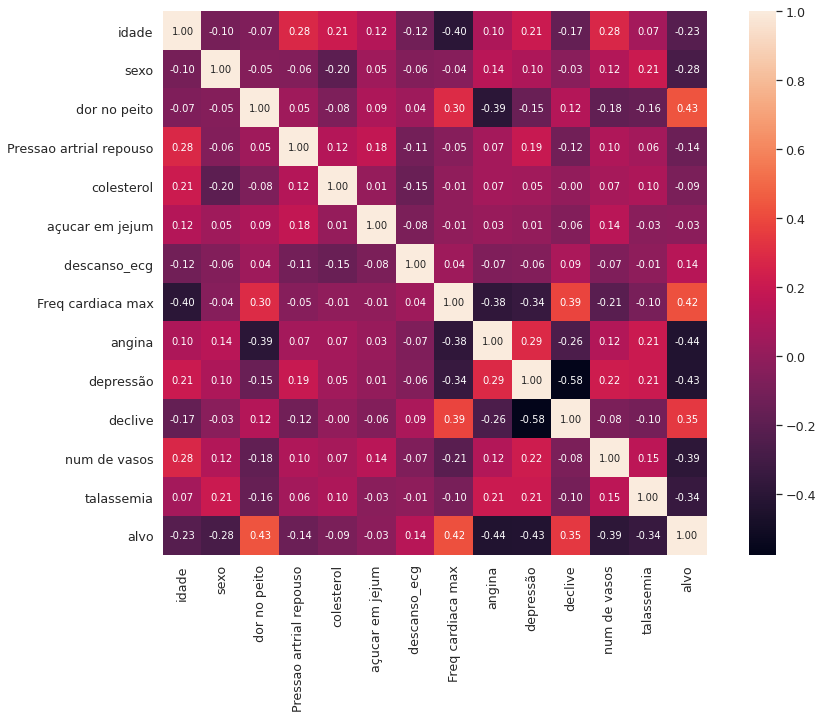

In [74]:
# Plotando um mapa de calor das correlações com todas as variáveis

corrmat = df.corr()
sns.set(font_scale=1.15)
f, ax = plt.subplots(figsize=(15, 10))
hm = sns.heatmap(corrmat, 
                 cbar=True, # formatando a barra lateral de cores para o heatmap
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

In [75]:
# contagem dos valores da variável target
df['alvo'].value_counts()

1    165
0    138
Name: alvo, dtype: int64

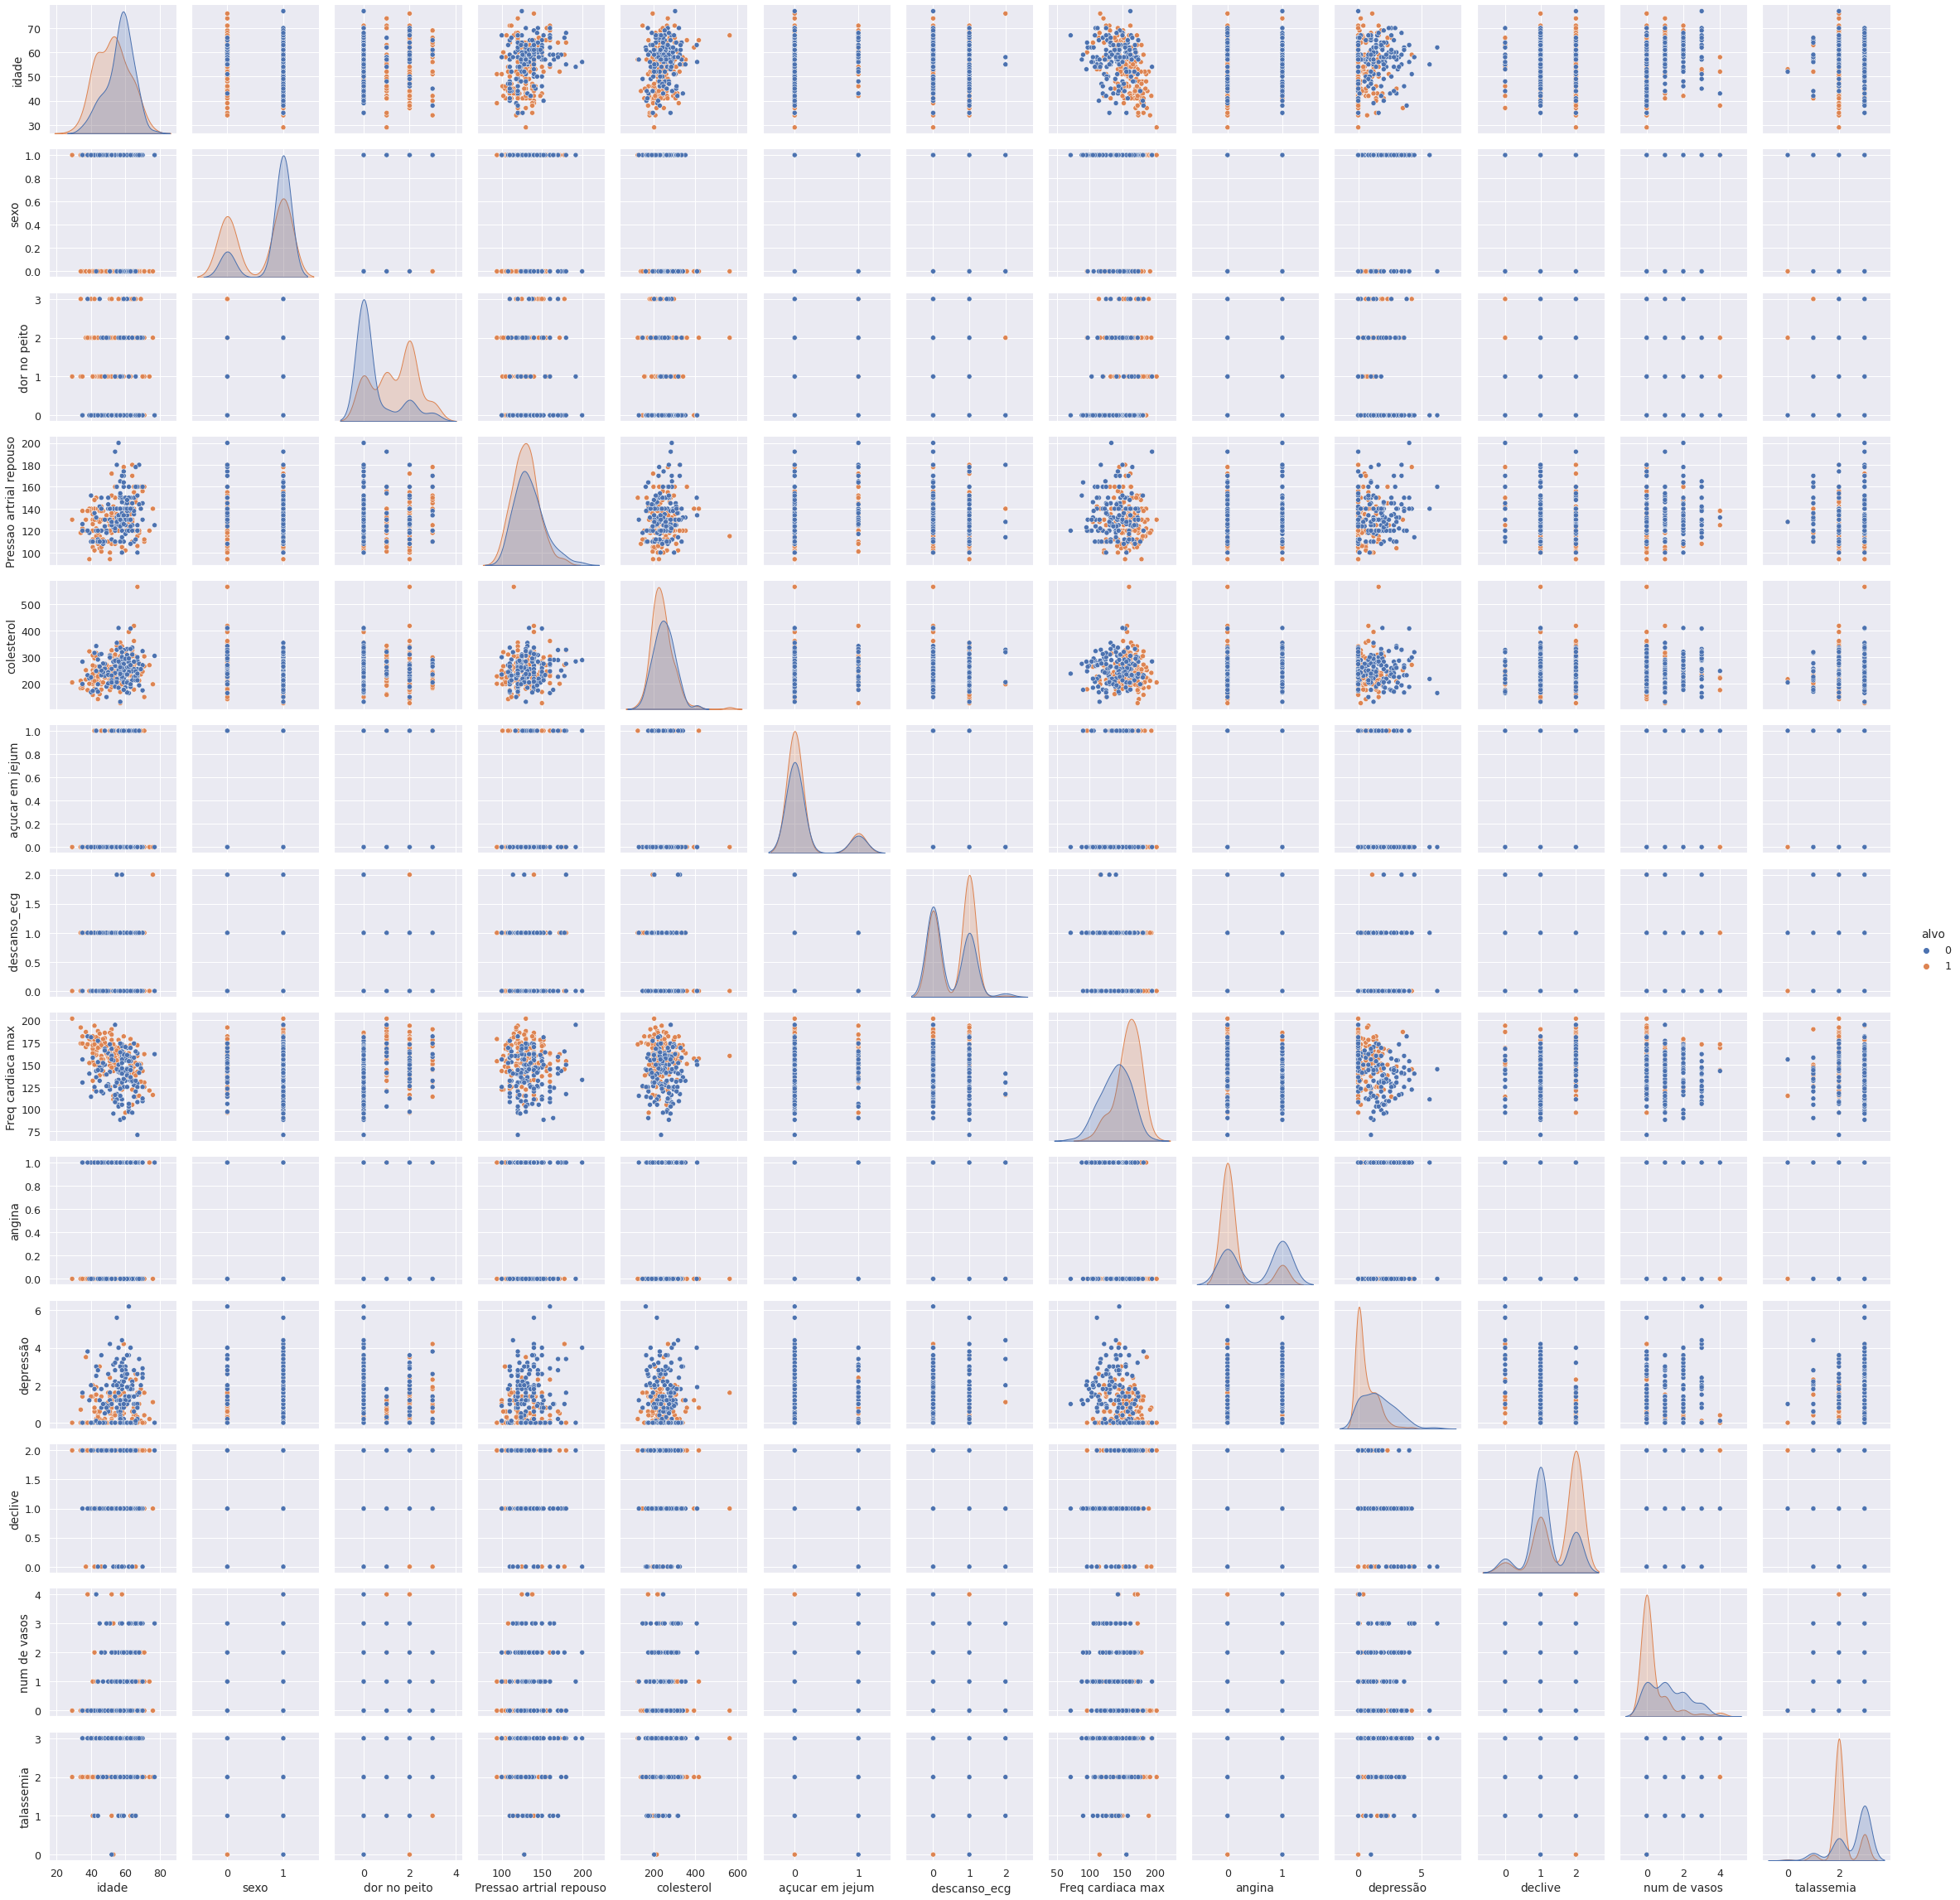

In [76]:
# Plotando o PAIPLOT para todas as variáveis 
sns.pairplot(df,hue='alvo')

In [78]:
df['sexo'][df['sexo'] == 0] = 'feminino'
df['sexo'][df['sexo'] == 1] = 'masculino'

df['dor no peito'][df['dor no peito'] == 1] = 'tipica angina'
df['dor no peito'][df['dor no peito'] == 2] = 'atipica angina'
df['dor no peito'][df['dor no peito'] == 3] = 'não é dor anginal'
df['dor no peito'][df['dor no peito'] == 4] = 'assintomático'

df['açucar em jejum'][df['açucar em jejum'] == 0] = ' abaixo de  120mg/ml'
df['açucar em jejum'][df['açucar em jejum'] == 1] = 'acima de  120mg/ml'

df['descanso_ecg'][df['descanso_ecg'] == 0] = 'normal'
df['descanso_ecg'][df['descanso_ecg'] == 1] = 'Anormalidade onda ST-T'
df['descanso_ecg'][df['descanso_ecg'] == 2] = 'hipertrofia ventricular esquerda'

df['angina'][df['angina'] == 0] = 'não'
df['angina'][df['angina'] == 1] = 'sim'

df['declive'][df['declive'] == 1] = 'para cima'
df['declive'][df['declive'] == 2] = 'plano'
df['declive'][df['declive'] == 3] = 'para baixo'

df['talassemia'][df['talassemia'] == 1] = 'normal'
df['talassemia'][df['talassemia'] == 2] = 'defeito corrigido'
df['talassemia'][df['talassemia'] == 3] = 'defeito reversivel'

KeyError: ignored